**Step 1: Setting Up Google Colab**

**Connect to Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Navigate to Your Dataset Folder**

In [3]:
import os
os.listdir("/content/drive/My Drive/Zeotap/")

['Customers.csv',
 'Products.csv',
 'Transactions.csv',
 'EDA_Report.txt',
 'Merged file.csv']

**Step 2: Install Required Libraries**

In [4]:
!pip install pandas numpy matplotlib seaborn scikit-learn

**Step 3: Load the Data**

In [6]:
import pandas as pd
import os

# Define the path to your dataset folder
dataset_folder = "/content/drive/My Drive/Zeotap/"

# Load the datasets using the full path
customers = pd.read_csv(os.path.join(dataset_folder, "Customers.csv"))
transactions = pd.read_csv(os.path.join(dataset_folder, "Transactions.csv"))
products = pd.read_csv(os.path.join(dataset_folder, "Products.csv"))

# Display first few rows
print(customers.head())
print(transactions.head())
print(products.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067   2024-04-25 7:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  
  ProductID              ProductName     Category   Price
0      P001

**Step 3: Data Preprocessing & Feature Engineering**

In [12]:
# Merge transactions with product data, specifying suffixes to avoid conflicts
transactions = transactions.merge(products, on="ProductID", how="left", suffixes=("_trans", "_prod"))

# Merge transactions with customer data
data = transactions.merge(customers, on="CustomerID", how="left")

# Aggregate customer-level features
customer_features = data.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total money spent
    "Quantity": "sum",    # Total products bought
    "Category": lambda x: list(x),  # List of purchased categories
    "Region": "first"  # Customer location
}).reset_index()

print(customer_features.head())

  CustomerID  TotalValue  Quantity  \
0      C0001     3354.52        12   
1      C0002     1862.74        10   
2      C0003     2725.38        14   
3      C0004     5354.88        23   
4      C0005     2034.24         7   

                                            Category         Region  
0  [Books, Home Decor, Electronics, Electronics, ...  South America  
1       [Home Decor, Home Decor, Clothing, Clothing]           Asia  
2    [Home Decor, Home Decor, Clothing, Electronics]  South America  
3  [Books, Home Decor, Home Decor, Home Decor, Bo...  South America  
4             [Home Decor, Electronics, Electronics]           Asia  


**Step 4: Encode Categorical Features**

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

# Encode 'Region'
le = LabelEncoder()
customer_features["Region"] = le.fit_transform(customer_features["Region"])

# Encode 'Category' using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
category_encoded = pd.DataFrame(mlb.fit_transform(customer_features["Category"]),
                                columns=mlb.classes_)

# Merge encoded category data
customer_features = pd.concat([customer_features.drop("Category", axis=1), category_encoded], axis=1)

print(customer_features.head())


  CustomerID  TotalValue  Quantity  Region  Books  Clothing  Electronics  \
0      C0001     3354.52        12       3      1         0            1   
1      C0002     1862.74        10       0      0         1            0   
2      C0003     2725.38        14       3      0         1            1   
3      C0004     5354.88        23       3      1         0            1   
4      C0005     2034.24         7       0      0         0            1   

   Home Decor  
0           1  
1           1  
2           1  
3           1  
4           1  


**Step 5: Apply Clustering Algorithm**

In [14]:
from sklearn.cluster import KMeans

# Selecting features for clustering
X = customer_features.drop(columns=["CustomerID"])

# Define number of clusters (let’s try 5 first)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
customer_features["Cluster"] = kmeans.fit_predict(X)

print(customer_features.head())


  CustomerID  TotalValue  Quantity  Region  Books  Clothing  Electronics  \
0      C0001     3354.52        12       3      1         0            1   
1      C0002     1862.74        10       0      0         1            0   
2      C0003     2725.38        14       3      0         1            1   
3      C0004     5354.88        23       3      1         0            1   
4      C0005     2034.24         7       0      0         0            1   

   Home Decor  Cluster  
0           1        2  
1           1        4  
2           1        4  
3           1        1  
4           1        4  


**Step 7: Evaluate Clustering with DB Index**

In [15]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(X, customer_features["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.5253878292611609


**Step 7: Visualize Clusters**

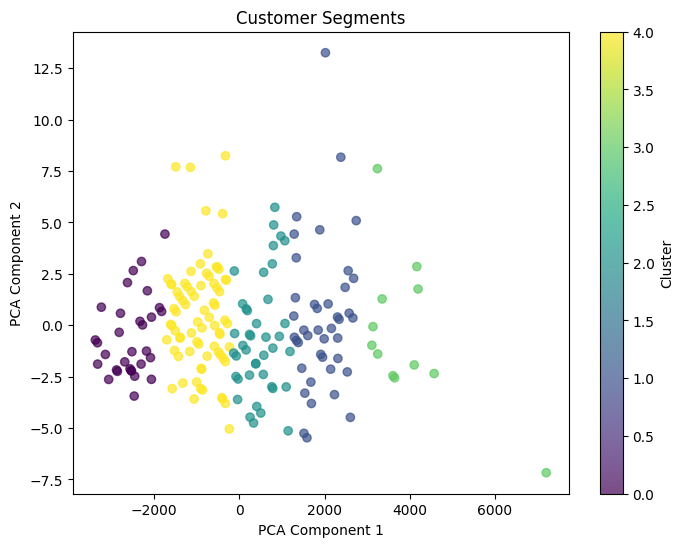

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce data to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_features["Cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Segments")
plt.colorbar(label="Cluster")
plt.show()


**Step 8: Save Clustering Results**

In [18]:
customer_features[["CustomerID", "Cluster"]].to_csv("Customer_Segments.csv", index=False)

Download the File

In [19]:
from google.colab import files
files.download("Customer_Segments.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>